In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import shutil
from tqdm import tqdm

In [11]:
data_dir = "./data" 

train_subdir = os.path.join(data_dir, "train")
test_subdir  = os.path.join(data_dir, "test")
class_name = "tank"   
img_size = (32, 32)
batch_size = 64
latent_dim = 100
generated_dir = "./generated_tank"
os.makedirs(generated_dir, exist_ok=True)

In [12]:
def load_images_from_folder(folder, max_images=None, target_size=(32,32)):
    files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    if max_images:
        files = files[:max_images]
    imgs = []
    for f in files:
        img = load_img(f, target_size=target_size)
        arr = img_to_array(img)
        imgs.append(arr)
    return np.array(imgs, dtype='float32'), files

train_class_folder = os.path.join(train_subdir, class_name)
test_class_folder  = os.path.join(test_subdir, class_name)

X_real_train, train_files = load_images_from_folder(train_class_folder, max_images=None, target_size=img_size)
X_real_test,  test_files  = load_images_from_folder(test_class_folder,  max_images=None, target_size=img_size)

print("Real train images:", X_real_train.shape)
print("Real test images :", X_real_test.shape)

X_real_train_gan = (X_real_train / 127.5) - 1.0

Real train images: (500, 32, 32, 3)
Real test images : (100, 32, 32, 3)


In [13]:
def build_generator(latent_dim=100):
    model = models.Sequential()
    model.add(layers.Dense(8*8*128, activation='relu', input_dim=latent_dim))
    model.add(layers.Reshape((8,8,128)))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128, kernel_size=3, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, kernel_size=3, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2D(3, kernel_size=3, padding='same', activation='tanh'))
    return model

In [15]:
def build_discriminator(input_shape=(32,32,3)):
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

generator = build_generator(latent_dim)
discriminator = build_discriminator((32,32,3))
discriminator.compile(optimizer=optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
z = layers.Input(shape=(latent_dim,))
img = generator(z)
valid = discriminator(img)
gan = models.Model(z, valid)
gan.compile(optimizer=optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')

generator.summary()
discriminator.summary()

e:\PythonDeep\environments\deep_learning\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
e:\PythonDeep\environments\deep_learning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │       827,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,051,267 (4.01 MB)

 Trainable params: 1,050,883 (4.01 MB)

 Non-trainable params: 384 (1.50 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,841 (327.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 83,841 (327.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


e:\PythonDeep\environments\deep_learning\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:86: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/2000 [D loss: 0.6540, acc_real: 0.812, acc_fake: 0.516] [G loss: 0.6390]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

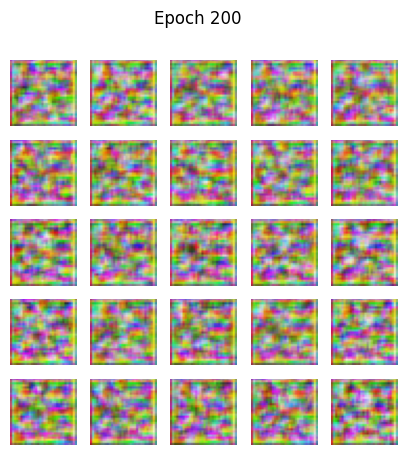

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

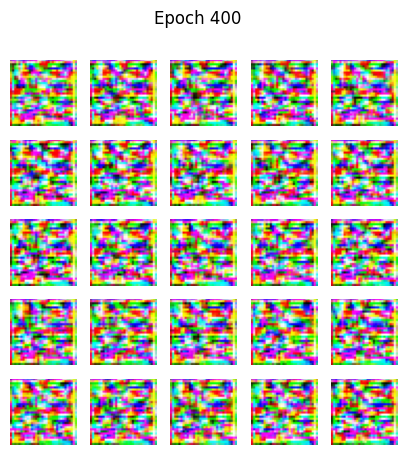

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

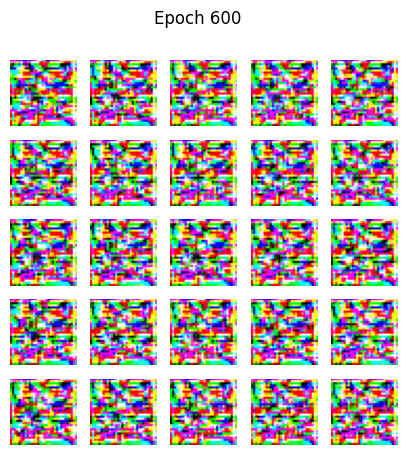

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

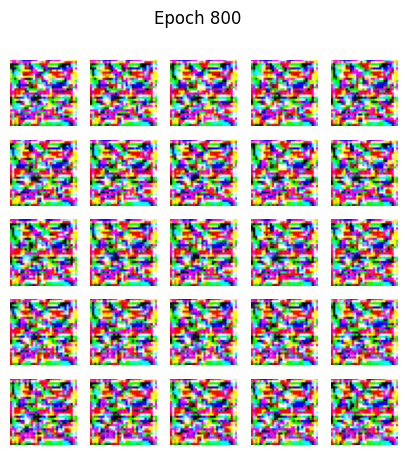

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

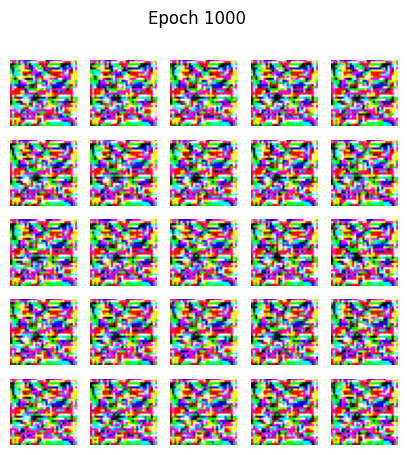

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

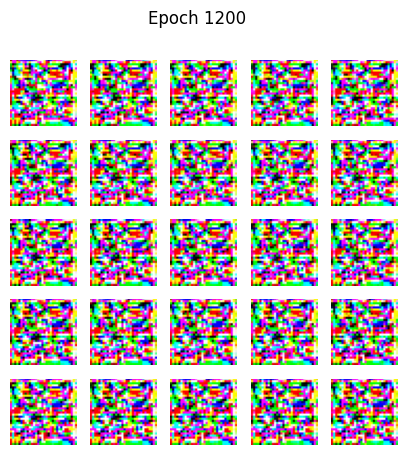

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

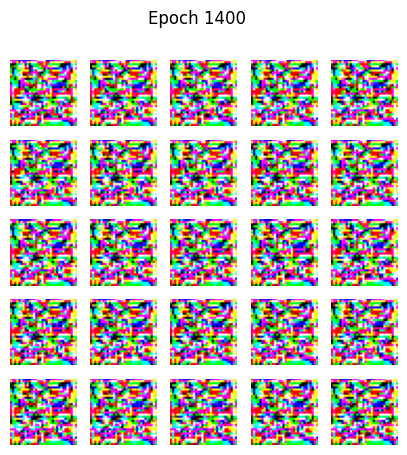

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

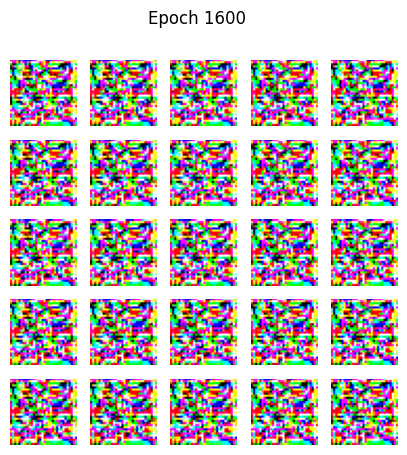

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

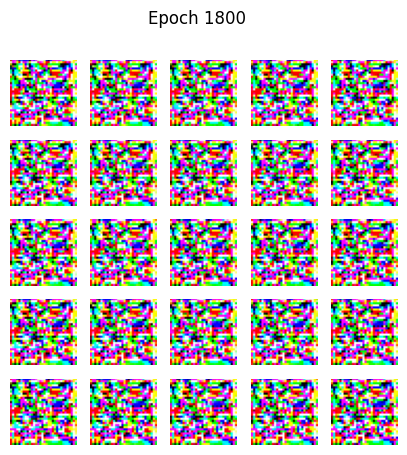

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

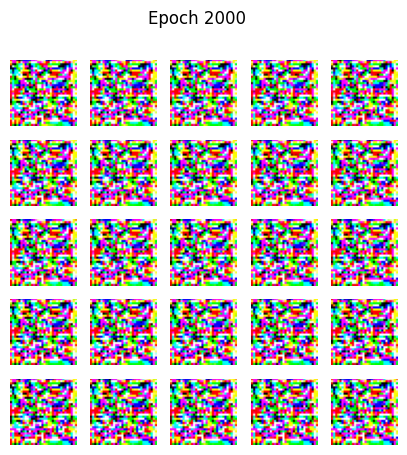

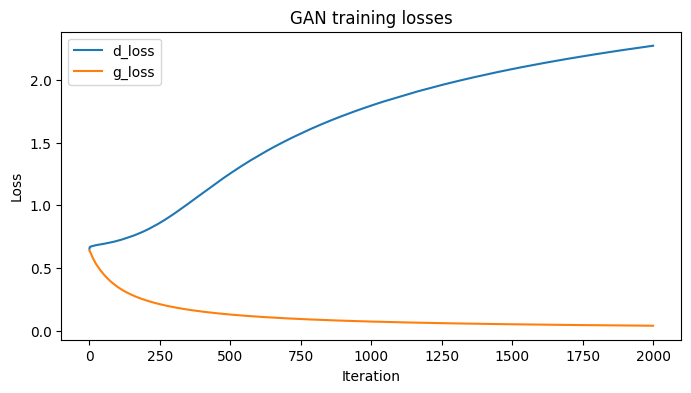

In [16]:
gan_epochs = 2000       
save_interval = 200     
batch_size = 64

half_batch = batch_size // 2
d_losses = []
g_losses = []

for epoch in range(gan_epochs):
   
    idx = np.random.randint(0, X_real_train_gan.shape[0], half_batch)
    real_imgs = X_real_train_gan[idx]

    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    fake_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch,1)))
    d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch,1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1)) 
    g_loss = gan.train_on_batch(noise, valid_y)

    d_losses.append(d_loss[0])
    g_losses.append(g_loss)

    if (epoch+1) % 100 == 0 or epoch==0:
        print(f"{epoch+1}/{gan_epochs} [D loss: {d_loss[0]:.4f}, acc_real: {d_loss_real[1]:.3f}, acc_fake: {d_loss_fake[1]:.3f}] [G loss: {g_loss:.4f}]")

    if (epoch+1) % save_interval == 0 or epoch == gan_epochs-1:
        sample_noise = np.random.normal(0,1,(25, latent_dim))
        gen_imgs = generator.predict(sample_noise)
        
        gen_imgs_disp = 0.5 * gen_imgs + 0.5
        
        fig = plt.figure(figsize=(5,5))
        for i in range(25):
            plt.subplot(5,5,i+1)
            plt.imshow(np.clip(gen_imgs_disp[i],0,1))
            plt.axis('off')
        plt.suptitle(f"Epoch {epoch+1}")
        plt.show()
        plt.close(fig)


plt.figure(figsize=(8,4))
plt.plot(d_losses, label='d_loss')
plt.plot(g_losses, label='g_loss')
plt.title("GAN training losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
n_generate = 500
noise = np.random.normal(0,1,(n_generate, latent_dim))
gen_imgs = generator.predict(noise)
gen_imgs_rescaled = 0.5 * gen_imgs + 0.5 

# save generated images to folder
for i in range(n_generate):
    arr = (gen_imgs_rescaled[i] * 255).astype(np.uint8)
    plt.imsave(os.path.join(generated_dir, f"gen_{i:04d}.png"), arr)

print(f"Saved {n_generate} generated images to {generated_dir}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Saved 500 generated images to ./generated_tank


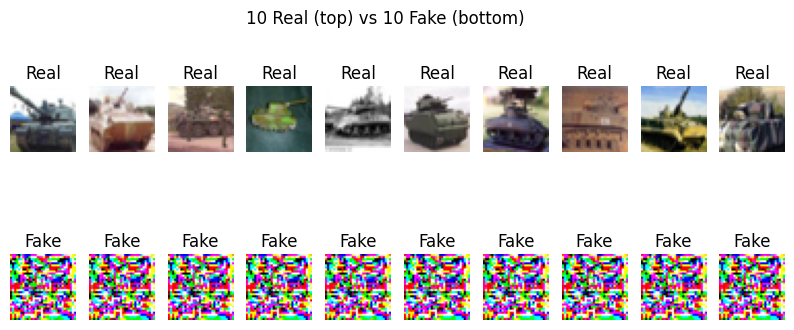

In [ ]:
n_show = 10
real_sample_idx = np.random.choice(X_real_test.shape[0], n_show, replace=False)
real_samples = X_real_test[real_sample_idx] / 255.0
fake_files = sorted([os.path.join(generated_dir,f) for f in os.listdir(generated_dir) if f.endswith('.png')])[:n_show]
fake_samples = np.array([img_to_array(load_img(f, target_size=img_size)) for f in fake_files]) / 255.0

plt.figure(figsize=(10,4))
for i in range(n_show):
    plt.subplot(2, n_show, i+1)
    plt.imshow(real_samples[i])
    plt.title("Real")
    plt.axis('off')
for i in range(n_show):
    plt.subplot(2, n_show, n_show+i+1)
    plt.imshow(fake_samples[i])
    plt.title("Fake")
    plt.axis('off')
plt.suptitle("10 Real (top) vs 10 Fake (bottom)")
plt.show()

# Beberapa pola warna dan tekstur pada gambar hasil generator memang mulai mirip dengan distribusi
# warna gambar asli, tetapi belum menghasilkan gambar yang berbentuk. Hal ini wajar untuk GAN
# yang dilatih dari dataset berukuran kecil (hanya satu kelas) dan jumlah epoch yang terbatas.
# GAN membutuhkan dataset besar dan training yang jauh lebih lama untuk menghasilkan gambar realistis.

In [19]:
real_for_clf = X_real_train[:n_generate] if X_real_train.shape[0] >= n_generate else X_real_train
real_for_clf = real_for_clf / 255.0
n_real = real_for_clf.shape[0]

# Fake images - load from generated_dir (use same count)
fake_list = sorted([os.path.join(generated_dir,f) for f in os.listdir(generated_dir) if f.endswith('.png')])[:n_real]
fake_for_clf = np.array([img_to_array(load_img(f, target_size=img_size)) for f in fake_list]) / 255.0
n_fake = fake_for_clf.shape[0]

X_clf = np.concatenate([real_for_clf, fake_for_clf], axis=0)
y_clf = np.concatenate([np.zeros(n_real), np.ones(n_fake)], axis=0)  

# shuffle and split train/val/test for classifier
X_train_clf, X_temp, y_train_clf, y_temp = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf)
X_val_clf, X_test_clf, y_val_clf, y_test_clf = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Classifier dataset sizes:", X_train_clf.shape, X_val_clf.shape, X_test_clf.shape)

Classifier dataset sizes: (700, 32, 32, 3) (150, 32, 32, 3) (150, 32, 32, 3)


e:\PythonDeep\environments\deep_learning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,081 (4.36 MB)

 Trainable params: 1,142,081 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8900 - loss: 0.4073 - val_accuracy: 1.0000 - val_loss: 0.1381
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.0495 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 8.3432e-04
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 5.1578e-04
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 1.0000 - loss: 7.1590e-04 - val_accuracy: 1.0000 - val_loss: 3.5398e-04
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 1.0000 - loss: 4.8130e-04 - val_accuracy: 1.0000 - val_loss: 2.3563e-04
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.0690e-0

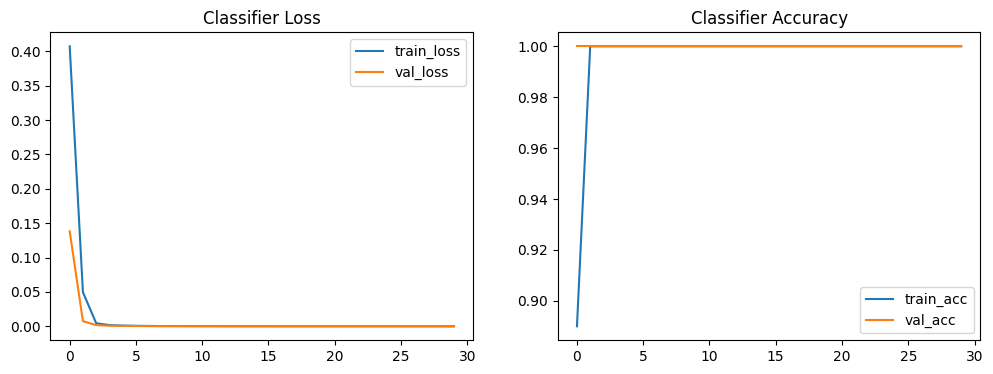

In [20]:
def build_classifier(input_shape=(32,32,3), base_filters=32, dropout=0.3):
    model = models.Sequential()
    model.add(layers.Conv2D(base_filters, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(base_filters*2, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(base_filters*4, (3,3), activation='relu', padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

clf = build_classifier()
clf.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
clf.summary()

clf_epochs = 30
history_clf = clf.fit(
    X_train_clf, y_train_clf,
    validation_data=(X_val_clf, y_val_clf),
    epochs=clf_epochs,
    batch_size=32,
    verbose=1
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_clf.history['loss'], label='train_loss')
plt.plot(history_clf.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Classifier Loss")
plt.subplot(1,2,2)
plt.plot(history_clf.history['accuracy'], label='train_acc')
plt.plot(history_clf.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Classifier Accuracy")
plt.show()

In [21]:
clf2 = build_classifier(base_filters=64, dropout=0.4)
clf2.compile(optimizer=optimizers.Adam(5e-4), loss='binary_crossentropy', metrics=['accuracy'])
hist2 = clf2.fit(X_train_clf, y_train_clf, validation_data=(X_val_clf, y_val_clf), epochs=15, batch_size=32, verbose=1)

# compare val_acc
print("Original val_acc:", max(history_clf.history['val_accuracy']))
print("Tuned val_acc   :", max(hist2.history['val_accuracy']))

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9700 - loss: 0.1150 - val_accuracy: 1.0000 - val_loss: 7.8499e-08
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.9917e-05 - val_accuracy: 1.0000 - val_loss: 2.4125e-09
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 2.5358e-06 - val_accuracy: 1.0000 - val_loss: 1.3417e-09
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 1.8575e-06 - val_accuracy: 1.0000 - val_loss: 9.3736e-10
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 1.0000 - loss: 6.6816e-06 - val_accuracy: 1.0000 - val_loss: 5.0684e-10
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 3.6889e-06 - val_accuracy: 1.0000 - val_loss: 1.3964e-10
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.1942e-06 - val_accuracy: 1.0000 - val_loss: 8.7823e-11
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step -

In [22]:
y_pred_prob = clf2.predict(X_test_clf)
y_pred = (y_pred_prob.flatten() >= 0.5).astype(int)

acc = accuracy_score(y_test_clf, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test_clf, y_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_test_clf, y_pred)

print("Test Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 score:", f1)
print("Confusion Matrix:\n", cm)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Test Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
Confusion Matrix:
 [[75  0]
 [ 0 75]]


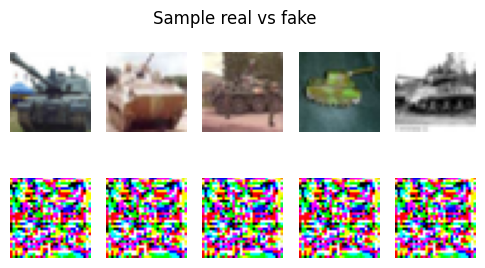

Generated images in: ./generated_tank


In [25]:
plt.figure(figsize=(6,3))
for i in range(5):
    plt.subplot(2,5,i+1); plt.imshow(real_samples[i]); plt.axis('off')
for i in range(5):
    plt.subplot(2,5,5+i+1); plt.imshow(fake_samples[i]); plt.axis('off')
plt.suptitle("Sample real vs fake")
plt.savefig("sample_real_vs_fake.png", bbox_inches='tight')
plt.show()

print("Generated images in:", generated_dir)